<a href="https://colab.research.google.com/github/RamyaKGokul/Python-DL-Projects/blob/main/Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification using the CIFAR-10 dataset
## Set Up


In [1]:
from __future__ import print_function
from tensorflow import keras
from keras import Sequential
from keras import layers
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import SGD,Adam
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
import os


from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers.experimental import preprocessing

import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import itertools

%matplotlib inline

import random

import tensorflow as tf
from collections import defaultdict
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay


## Load dataset

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.3)
#One hot encode the labels.Since we have 10 classes we should expect the shape[1] of y_train,y_val and y_test to change from 1 to 10
y_train1=to_categorical(y_train)
y_val1=to_categorical(y_val)
y_test1=to_categorical(y_test)

170498071/170498071 [==============================] - 4s 0us/step


## Displaying an image randomly from the dataset

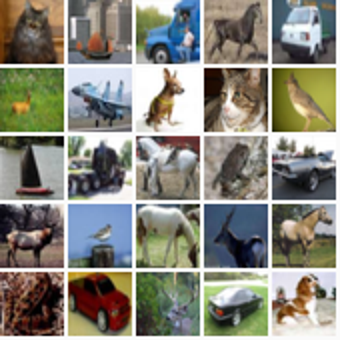

In [3]:
# Show collage of 25 (randomly selected) images
num_classes = max(y_test)+1
height_width = 32
def show_collage(examples):
    box_size = height_width + 2
    num_rows, num_cols = examples.shape[:2]

    collage = Image.new(
        mode="RGB",
        size=(num_cols * box_size, num_rows * box_size),
        color=(250, 250, 250),
    )
    for row_idx in range(num_rows):
        for col_idx in range(num_cols):
            array = (np.array(examples[row_idx, col_idx]) * 255).astype(np.uint8)
            collage.paste(
                Image.fromarray(array), (col_idx * box_size, row_idx * box_size)
            )

    # Double size for visualisation.
    collage = collage.resize((2 * num_cols * box_size, 2 * num_rows * box_size))
    return collage

# Show a collage of 5x5 random images.
sample_idxs = np.random.randint(0, 35000, size=(5, 5))
x_train = x_train.astype("float32") / 255.0
examples = x_train[sample_idxs]
show_collage(examples)



Bird


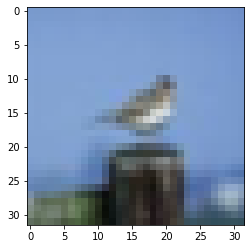

In [4]:
# Testing the first training data point
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
idx = int(y_train[0])
print(labels[idx])
plt.imshow(x_train[0])

## Building the model

In [5]:
base_model= ResNet50(include_top=False,
                     weights='imagenet',
                     input_shape=(32,32,3),
                     classes=y_train.shape[1])
model=Sequential()
model.add(base_model)
model.add(Dense(4000,activation=('relu')))
model.add(Dense(2000,activation=('relu'))) 
model.add(Dense(1000,activation=('relu'))) 
model.add(Dense(500,activation=('relu')))
model.add(Flatten())
model.add(Dense(10,activation=('softmax')))

94765736/94765736 [==============================] - 1s 0us/step


In [6]:
batch_size= 128
epochs=40
learn_rate=.001

sgd=SGD(learning_rate=learn_rate,momentum=.9,nesterov=False)
adam=Adam(learning_rate=learn_rate)

## Compiling and Training the model

In [ ]:
# Compile the model
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Train the model
history_1 = model.fit(x_train, y_train1,
              batch_size=batch_size,
              epochs=epochs,
              verbose = 1,
              validation_data=(x_val, y_val1),
              shuffle=True)

## Model Accuracy

In [8]:
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

## Evaluating the model

In [ ]:
# Score trained model.
scores = model.evaluate(x_test, y_test1, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])


In [10]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

# Printing Confusion Matrix

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)

In [ ]:
predict_x=model.predict(x_test) 
y_pred=np.argmax(predict_x,axis=1)
y_true=np.argmax(y_test1,axis=1)

#Compute the confusion matrix
confusion_mtx=confusion_matrix(y_true,y_pred)

In [ ]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=labels,
                      title='Confusion matrix')

## Error Inspection

In [ ]:
# Inspect errors
R = 3
C = 5
fig, axes = plt.subplots(R, C, figsize=(12,8))
axes = axes.ravel()

misclassified_idx = np.where(y_pred != y_true)[0]
for i in np.arange(0, R*C):
    axes[i].imshow(x_test[misclassified_idx[i]])
    axes[i].set_title("True: %s \nPredicted: %s" % (labels[y_true[misclassified_idx[i]]], 
                                                  labels[y_pred[misclassified_idx[i]]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

In [ ]:
def show_test(number):
    fig = plt.figure(figsize = (3,3))
    test_image = np.expand_dims(x_test[number], axis=0)
    predict_x=model.predict(test_image) 
    test_result=np.argmax(predict_x,axis=1)
    plt.imshow(x_test[number])
    dict_key = test_result[0]
    plt.title("Predicted: {} \nTrue Label: {}".format(labels[dict_key],
                                                      labels[y_true[number]]))
show_test(20)